In [79]:
import pandas as pd
import pandas.api.types as ptypes
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [80]:
df = pd.read_csv("impute_check.csv")

In [81]:
df.shape

(131021, 147)

In [82]:
df.drop(['bilirubin_apache','albumin_apache','urineoutput_apache'],inplace=True,axis=1)

In [83]:
df.drop(['D','encounter_id','hospital_id','patient_id'],inplace=True,axis=1)

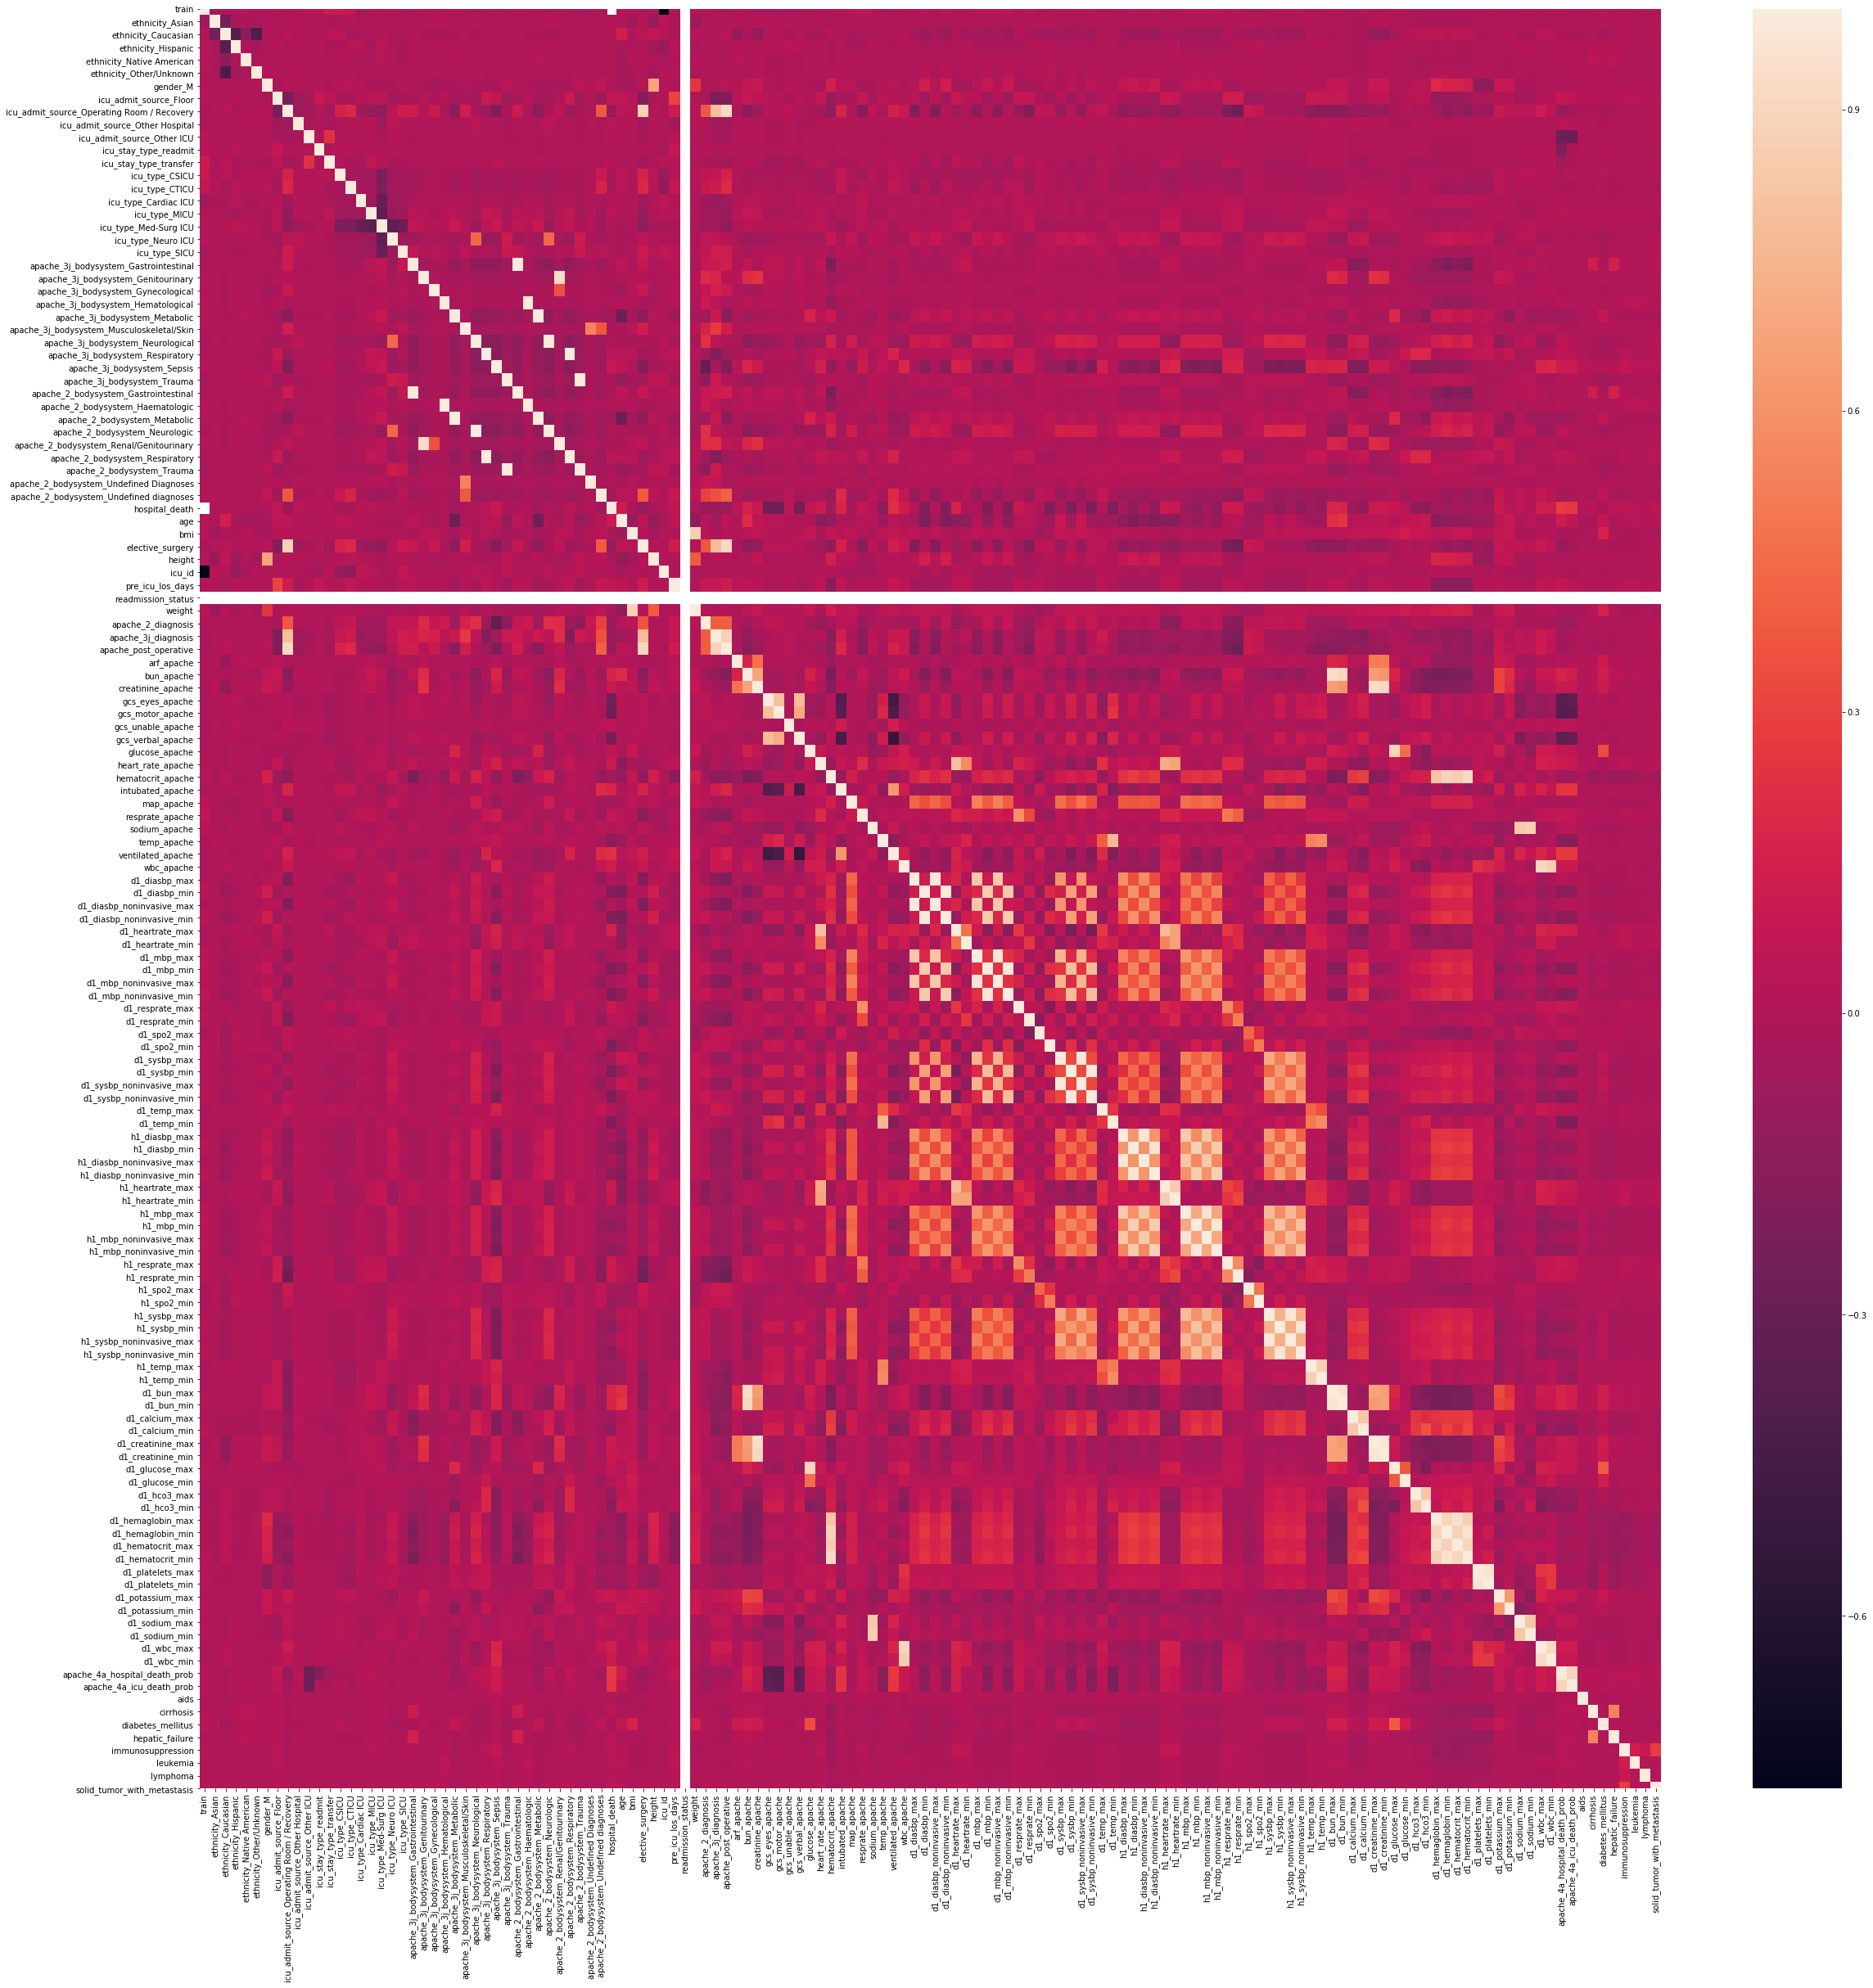

In [84]:
plt.subplots(figsize=(40,40))
sns.heatmap(df.corr())

In [85]:
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

In [86]:
to_drop

['apache_2_bodysystem_Gastrointestinal',
 'apache_2_bodysystem_Haematologic',
 'apache_2_bodysystem_Metabolic',
 'apache_2_bodysystem_Neurologic',
 'apache_2_bodysystem_Renal/Genitourinary',
 'apache_2_bodysystem_Respiratory',
 'apache_2_bodysystem_Trauma',
 'elective_surgery',
 'weight',
 'apache_post_operative',
 'd1_diasbp_noninvasive_max',
 'd1_diasbp_noninvasive_min',
 'd1_mbp_min',
 'd1_mbp_noninvasive_max',
 'd1_mbp_noninvasive_min',
 'd1_sysbp_noninvasive_max',
 'd1_sysbp_noninvasive_min',
 'h1_diasbp_noninvasive_max',
 'h1_diasbp_noninvasive_min',
 'h1_heartrate_min',
 'h1_mbp_min',
 'h1_mbp_noninvasive_max',
 'h1_mbp_noninvasive_min',
 'h1_sysbp_noninvasive_max',
 'h1_sysbp_noninvasive_min',
 'h1_temp_min',
 'd1_bun_max',
 'd1_bun_min',
 'd1_creatinine_max',
 'd1_creatinine_min',
 'd1_glucose_max',
 'd1_hemaglobin_min',
 'd1_hematocrit_max',
 'd1_hematocrit_min',
 'd1_platelets_min',
 'd1_sodium_min',
 'd1_wbc_max',
 'd1_wbc_min',
 'apache_4a_icu_death_prob']

In [87]:
df = df.drop(df[to_drop], axis=1)

In [88]:
df.shape

(131021, 101)

In [89]:
df.columns

Index(['train', 'ethnicity_Asian', 'ethnicity_Caucasian', 'ethnicity_Hispanic',
       'ethnicity_Native American', 'ethnicity_Other/Unknown', 'gender_M',
       'icu_admit_source_Floor', 'icu_admit_source_Operating Room / Recovery',
       'icu_admit_source_Other Hospital',
       ...
       'd1_sodium_max', 'apache_4a_hospital_death_prob', 'aids', 'cirrhosis',
       'diabetes_mellitus', 'hepatic_failure', 'immunosuppression', 'leukemia',
       'lymphoma', 'solid_tumor_with_metastasis'],
      dtype='object', length=101)

In [90]:
train = df[df['train'] == 1]

In [91]:
train.shape

(91713, 101)

In [92]:
train.columns

Index(['train', 'ethnicity_Asian', 'ethnicity_Caucasian', 'ethnicity_Hispanic',
       'ethnicity_Native American', 'ethnicity_Other/Unknown', 'gender_M',
       'icu_admit_source_Floor', 'icu_admit_source_Operating Room / Recovery',
       'icu_admit_source_Other Hospital',
       ...
       'd1_sodium_max', 'apache_4a_hospital_death_prob', 'aids', 'cirrhosis',
       'diabetes_mellitus', 'hepatic_failure', 'immunosuppression', 'leukemia',
       'lymphoma', 'solid_tumor_with_metastasis'],
      dtype='object', length=101)

In [93]:
test =  df[df['train'] == 0]

In [94]:
test.shape

(39308, 101)

In [99]:
Y = train['hospital_death']
X = train.drop(columns=['train','hospital_death'],axis=1)

In [100]:
X.shape

(91713, 99)

In [101]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X)
# Apply transform to both the training set and the test set.
X = scaler.transform(X)

In [116]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.30, random_state=40,stratify=Y)


In [117]:
from keras.models import Sequential
from keras.layers import Dense

def build_model():
    model = Sequential()
    model.add(Dense(99, input_dim=99, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

from keras.wrappers.scikit_learn import KerasClassifier
keras_model = build_model()
keras_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

In [127]:
score = keras_model.evaluate(X_test, y_test, verbose=0)

In [128]:
print(score)

[0.3214339281164855, 0.9113178849220276]


In [118]:
from sklearn.metrics import roc_curve
y_pred_keras = keras_model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [120]:
print(auc_keras)

0.8303040316890719


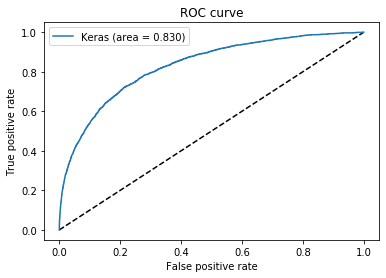

In [121]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [136]:
classifier = Sequential()
#First Hidden Layer
classifier.add(Dense(99, activation='relu', kernel_initializer='random_normal', input_dim=99))
#Second  Hidden Layer
classifier.add(Dense(60, activation='relu', kernel_initializer='random_normal'))
#Output Layer
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

In [137]:
#Compiling the neural network
classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])

In [138]:
#Fitting the data to the training dataset
classifier.fit(X_train,y_train, batch_size=10, epochs=50)

Epoch 1/50
64199/64199 [==============================] - 17s 272us/step - loss: 0.2113 - accuracy: 0.9237
Epoch 2/50
64199/64199 [==============================] - 17s 267us/step - loss: 0.1975 - accuracy: 0.9276
Epoch 3/50
64199/64199 [==============================] - 17s 269us/step - loss: 0.1917 - accuracy: 0.9299
Epoch 4/50
64199/64199 [==============================] - 18s 276us/step - loss: 0.1859 - accuracy: 0.9317
Epoch 5/50
64199/64199 [==============================] - 17s 263us/step - loss: 0.1800 - accuracy: 0.9339
Epoch 6/50
64199/64199 [==============================] - 17s 258us/step - loss: 0.1746 - accuracy: 0.9362
Epoch 7/50
64199/64199 [==============================] - 17s 262us/step - loss: 0.1685 - accuracy: 0.9387
Epoch 8/50
64199/64199 [==============================] - 18s 280us/step - loss: 0.1623 - accuracy: 0.9410
Epoch 9/50
64199/64199 [==============================] - 17s 271us/step - loss: 0.1573 - accuracy: 0.9436
Epoch 10/50
64199/64199 [============

In [139]:
eval_model=classifier.evaluate(X_train, y_train)
eval_model

64199/64199 [==============================] - 1s 22us/step


[0.036685466205305085, 0.9873051047325134]

In [140]:
y_pred=classifier.predict(X_test)
y_pred =(y_pred>0.5)

In [141]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[23780  1359]
 [ 1450   925]]


In [142]:
from sklearn.metrics import roc_curve
y_pred_c = classifier.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_c)

In [143]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [144]:
print(auc_keras)

0.7844900416840264
